# Time series forecasting

In [1]:
import warnings
from datetime import datetime

from torch.distributed.pipelining import pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pmdarima as pmd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.transformations.series.difference import Differencer

We will use [sktime](https://www.sktime.net/en/stable/index.html) as our main library for time series. It offers interface very similar to scikit-learn, and conveniently wraps many other libraries, for example:
- [statsforecast](https://github.com/Nixtla/statsforecast) - efficient implementations of many forecasting methods, e.g. AutoARIMA and AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - statistical tests for time series and another AutoARIMA implementation
- [statsmodels](https://www.statsmodels.org/stable/index.html) - a few time series decomposition and forecasting methods

For statistical tests we will use [scipy](https://docs.scipy.org/doc/scipy/index.html) and [statsmodels](https://www.statsmodels.org/stable/index.html).

## Forecasting Polish inflation

The problem of forecasting inflation (here defined using consumer price index, CPI) is very common, done by basically every country and larger financial institutions. In practice it's not a single task, but rather a collection of related problems, forecasting e.g. inflation, core inflation (excluding most volatile components, e.g. food and energy prices), and other formulations.

In Poland, basic data about inflation [is published by the Central Statistical Office of Poland (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), with monthly, quarterly, half-yearly and yearly frequency. More detailed information is published by other institutions, because they depend on the methodology used, e.g. core inflation [is calculated and published by the National Bank of Poland (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Forecasting inflation is a challenge, since it typically:
- has visible cycles, but very irregular
- is implicitly tied to many external factors (global economy, political decisions etc.)
- there is no apparent seasonality
- we are interested in forecasting with many frequencies, e.g. monthly (short-term decisions) and yearly (long-term decisions)

We will use GUS data with monthly frequency. To get a percentage value (annual percentage rate inflation) from the raw data, we need to subtract 100 from provided values.

In [2]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100

# filter out NaN values from the end of the series
df = df[~df.isna()]

df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2024-04      2.4
2024-05      2.5
2024-06      2.6
2024-07      4.2
2024-08      4.3
Freq: M, Name: value, Length: 512, dtype: float64

To plot the time series, the easiest way is to use the [plot_series() function](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html) from sktime, which will automatically nicely format X and Y axes.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation'}, ylabel='value'>)

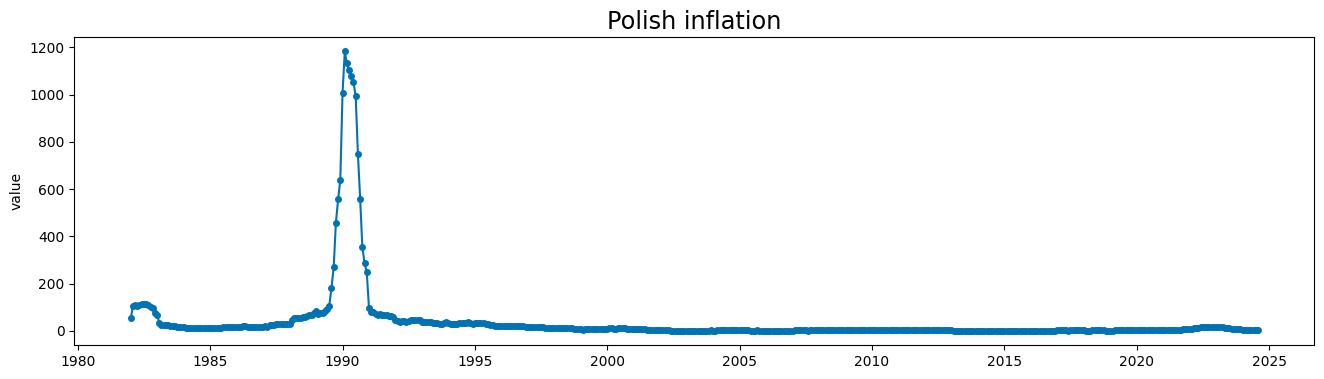

In [3]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

There is no error here - 90s were a particularly interesting period, with [hyperinflation](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), later ["shock therapy"](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) and implementation of the [Balcerowicz Plan](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). From the perspective of time series forecasting, this is definitely na outlier, but quite long. For this reason, we will limit ourselves to post-2000 data.

Similar behavior can often be seen in time series data, related to e.g. [2007-2008 financial crisis](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis) or COVID-19 pandemic. Such events can introduce shocks with long effects, and using only later data is arguably the simplest strategy to deal with this.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation, from year 2000'}, ylabel='value'>)

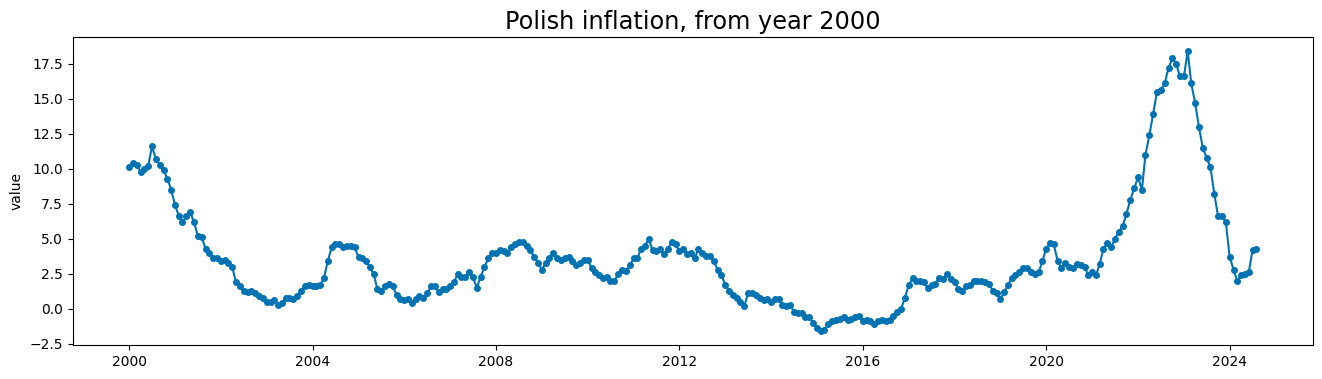

In [4]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000")

There is definitely some information here, with cycles and trends. Fortunately, the data seems to be changing reasonably slowly most of the time. But what about seasonality?

**Exercise 1 (0.5 points)**

Implement the `plot_stl_decomposition` function. Use `STLTransformer` to compute the STL decomposition ([documentation](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Remember to use appropriate arguments to set the seasonality period and return all three components.

Plot the resulting STL decomposition. Comment:
- do you see a yearly seasonality here?
- concerning residuals, are they only a white noise, or do they seem to contain some further information to use?

In [5]:
from sktime.transformations.series.detrend import STLTransformer


def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    transformer = STLTransformer(sp=seasonal_period, return_components=True)  
    data_transformed = transformer.fit_transform(data)
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
    plot_series(data, ax=axes[0], title="Polish inflation, from year 2000")
    plot_series(data_transformed['trend'], ax=axes[1], title="Polish inflation, from year 2000 - trend")
    plot_series(data_transformed['seasonal'], ax=axes[2], title="Polish inflation, from year 2000 - seasonal")
    plot_series(data_transformed['resid'], ax=axes[3], title="Polish inflation, from year 2000 - residuals")
    plt.show()

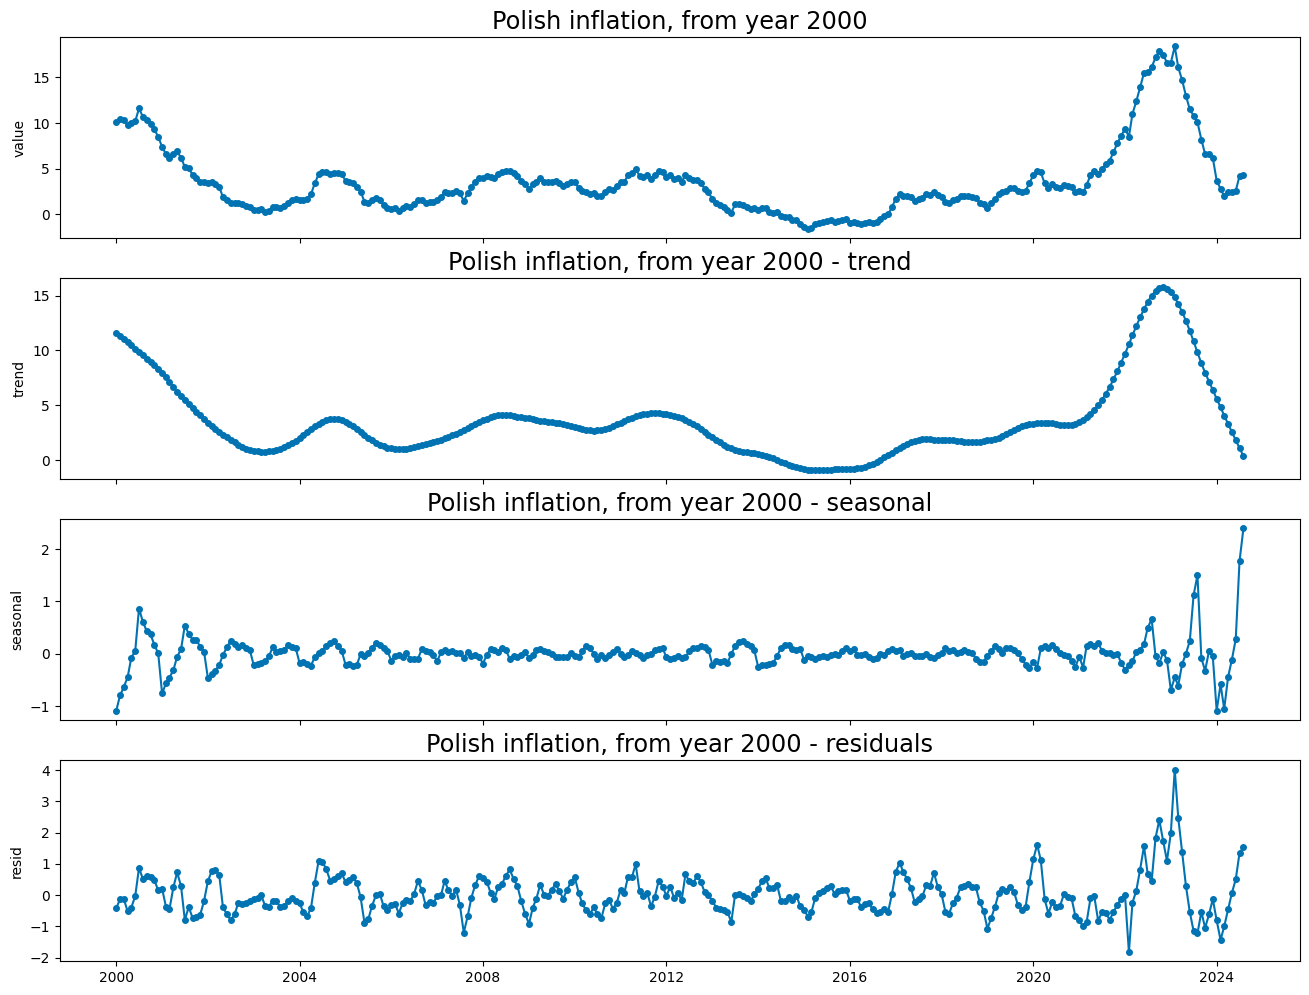

In [6]:
plot_stl_decomposition(df)

In given plot there is not visible seasonality, it is rather cyclical fluctuations - not regular.

The residuals not looking like white noice, this assumtion is hard to meet but residuals doesn't have any new information.

Manual check using STL decomposition is useful - this allows us to gain intuition and knowledge about the data, and validation parameters. Of course we also have automated procedures, using statistical tests, to avoid such manual labor when we can.

Let's check the seasonality and stationarity of our data. This is not strictly necessary for ETS models - they use the data as-is. However, the ARIMA models require stationary data, and knowledge about seasonality, or lack thereof, can greatly accelerate our experiments. SARIMA takes much longer than simpler ARIMA.

**Exercise 2 (0.75 points)**

1. Check, using statistical tests for seasonality, if there is a quarterly, half-yearly, or yearly seasonality in the data. Use the `nsdiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html)). If you detect seasonality, remove it using the `Differencer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) and plot the deasonalized series.

2. Check, using statistical tests for stationarity, what differencing order stationarizes the data. Use the `ndiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)). If it's greater than zero, i.e. differencing is necessary, then stationarize the series using the `Differencer` class and plot the resulting time series.

3. Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.

Use the default `D_max` and `d_max` values.

**Warning:** create new variables for values after differencing, do not overwrite the `df` variable. It will be used later.

In [7]:
print("seasonality 3 months: ", pmd.arima.nsdiffs(x=df, m=3))
print("seasonality 6 months: ", pmd.arima.nsdiffs(x=df, m=6))
print("seasonality 12 months: ", pmd.arima.nsdiffs(x=df, m=12))
# 0 - we don't need to do anything about seasonality, number of differencing

seasonality 3 months:  0
seasonality 6 months:  0
seasonality 12 months:  0


In [8]:
def make_stationarity(data) -> None:
    while pmd.arima.ndiffs(data) > 0:
        print("stationarity: ", pmd.arima.ndiffs(data))
        differencer = Differencer(lags=pmd.arima.ndiffs(data))
        data = differencer.fit_transform(data)
    plot_series(data, title='Polish inflation after 2000 - data after single differencing')
    print("stationarity: ", pmd.arima.ndiffs(data))
    return data

stationarity:  1
stationarity:  0


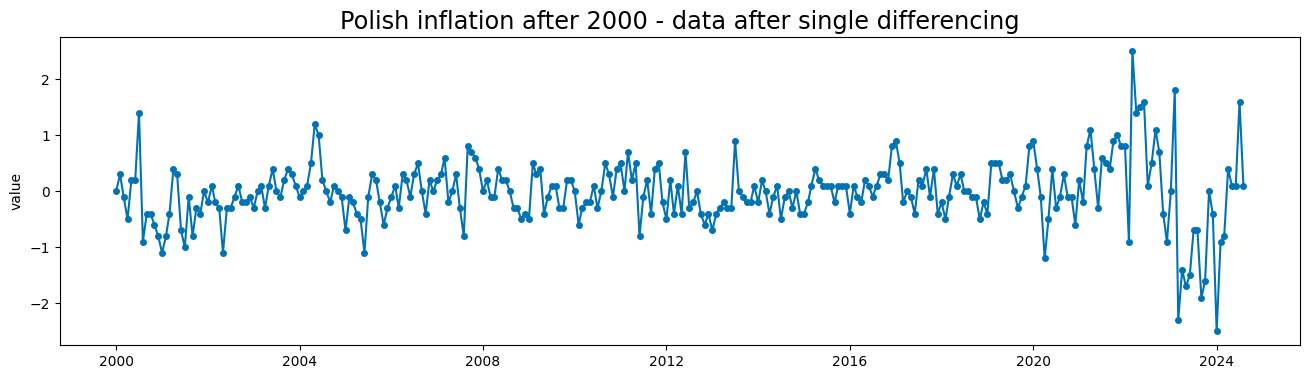

In [9]:
df_diff = make_stationarity(df)

// comment here

After using statistical tests to check seasonality with different length it occurs that there is no seasonality, similarly to looking at plot.

Stationarity test suggested a single differentiation which was performed.

After these tests I will use ARIMA because I need single differenation I=1, also I don't need SARIMA because a series doesn't have a seasonality.


We are now basically ready to train our forecasting models. We will use 20% of the newest data for testing, using the expanding window strategy, with step 1 (we get inflation reading each month). MAE and MASE will be used as quality metrics.

We will also perform residuals analysis. Errors should be normally distributed (unbiased mdoel) and do not have autocorrelation (model utilizing all available information). For all statistical tests we assume the significance level $\alpha = 0.05$.

For testing normality, the Anderson-Darling test is less conservative than Shapiro-Wilk test, which is quite useful in practice. Errors are very rarely close to "true" normality in real world. The null hypothesis is that values come from the given distributions (by default the normal one), and alternative hypothesis that they come from other distribution.

For testing error autocorrelation, the Ljung-Box test is used, which tests autocorrelation for various lags. For each lag, a separate test is performed. The null hypothesis is the lack of autocorrelation, and the alternative hypothesis is that there is an autocorrelation with a given lag.

**Exercise 3 (1.5 points)**

Implement the missing parts of the `evaluate_model` function:
1. Create `ExpandingWindowSplitter` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.ExpandingWindowSplitter.html)), which should start testing at 80% of data. The forecast window size is controlled via the `horizon` parameter.
2. Create a list of metric objects, consisting of MAE and MASE ([ocumentation](https://www.sktime.net/en/latest/api_reference/performance_metrics.html)).
3. Perform the model evaluation, using the `evaluate` function ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Pass `return_data=True`, in order to also return the computed forecasts. It returns a DataFrame with results.
4. Calculate average metric values, using the resulting DataFrame. Print them rounded to 2 decimal places.
5. Taking into consideration the `analyze_residuals` argument, perform the error analysis:
   - calculate residuals $y - \hat{y}$
   - plot the residuals histogram
   - perform the Anderson-Darling test ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)) and print whether the distribution is normal or not
   - perform the Ljung-Box test ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)) and print the test results

Test the function, using two baseline forecasting methods: average (mean) and last known value. Use the `NaiveForecaster` class ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), with 3 months forecasting horizon. Plot the forecasts, using the `plot_forecasts` argument.

In [34]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteScaledError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from statsmodels.stats.diagnostic import acorr_ljungbox
from sktime.split import ExpandingWindowSplitter

def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    

    cv = ExpandingWindowSplitter(initial_window=round(0.8*len(data)), fh=horizon, step_length=1)
    metrics = [MeanAbsoluteError(), MeanAbsoluteScaledError()]
    
    # model.fit(data)
    results = evaluate(forecaster=model, return_data=True, cv=cv, y=data, scoring=metrics)
    
    y_pred = pd.concat(results['y_pred'].values)
    
    mae = results['test_MeanAbsoluteError'].mean()
    mase = results['test_MeanAbsoluteScaledError'].mean()

    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.title('Polish inflation after 2000 - prediction')
        plt.show()
        plt.clf()

    
    if analyze_residuals:
        y_true = data.iloc[np.unique([i for _, test in cv.split(data) for i in test])]
        # y_true = data[y_pred.index]
        residual = y_true - y_pred
        plt.hist(residual, bins=20)
        plt.title("Residuals distribution")
        plt.show()
        print('anderson-darling test:\n', anderson(residual, dist='norm'))
        print('\n\nacorr_ljungbox:\n', acorr_ljungbox(residual))

In [11]:
from sktime.forecasting.naive import NaiveForecaster
mean_model = NaiveForecaster(strategy="mean")
last_model = NaiveForecaster(strategy="last")

# 1. Mean baseline

MAE: 4.79
MASE: 13.88


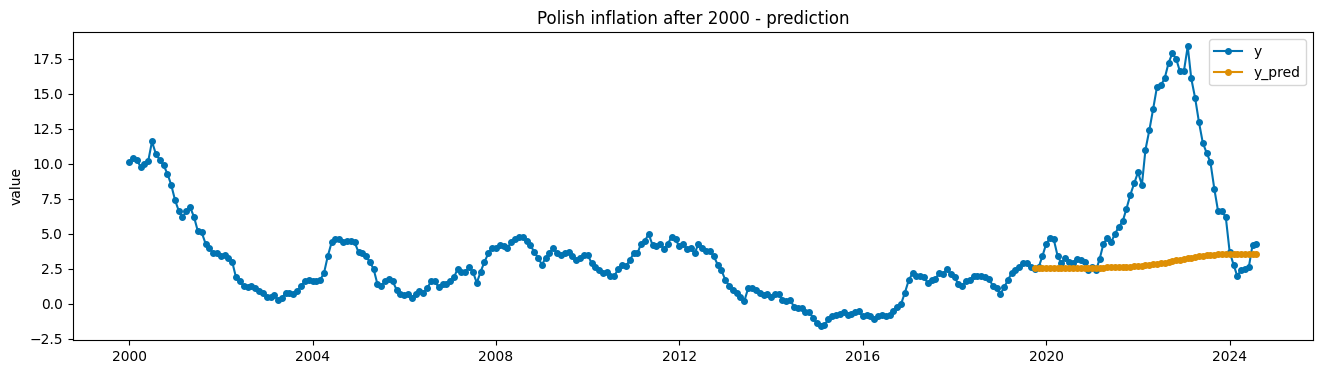

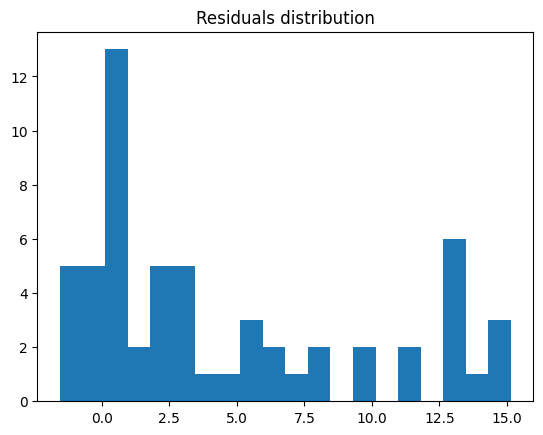

anderson-darling test:
 AndersonResult(statistic=3.216652345211145, critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.594771176894331, scale=5.1844081213229165)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


acorr_ljungbox:
        lb_stat     lb_pvalue
1    58.264000  2.292001e-14
2   111.861642  5.123339e-25
3   159.465779  2.390111e-34
4   200.249507  3.320699e-42
5   233.503499  1.897518e-48
6   258.651591  5.801989e-53
7   276.031580  7.881891e-56
8   286.747700  2.715847e-57
9   292.407825  1.063186e-57
10  294.494920  2.265156e-57


In [12]:
evaluate_model(data=df, model=mean_model, plot_forecasts=True, analyze_residuals=True)

\\ comment

Mean baseline couldn't fit well to bigger values of inflation in recent years. It predicts base on mean of previous data (values before were usually much smaller). It has started slithly grow but not enoughly.

Residual distribution is far from normal.

In Anderson-Darling test with significance level alpha=0.05: statistic=3.21 > critical_value=0.742, so the hypotesis zero about normal distribution is rejected. Residuals are not noramlly distributed as in the picture.

In Ljungbox test for every lag from 1 to 10, lb_pvalue < 0.05, so the hypotesis zero about no autocorrelation is rejected. The residuals has autocorrelation. This suggests that there is significant autocorrelation in the residuals at each lag.

# 2. Last baseline

MAE: 0.78
MASE: 2.28


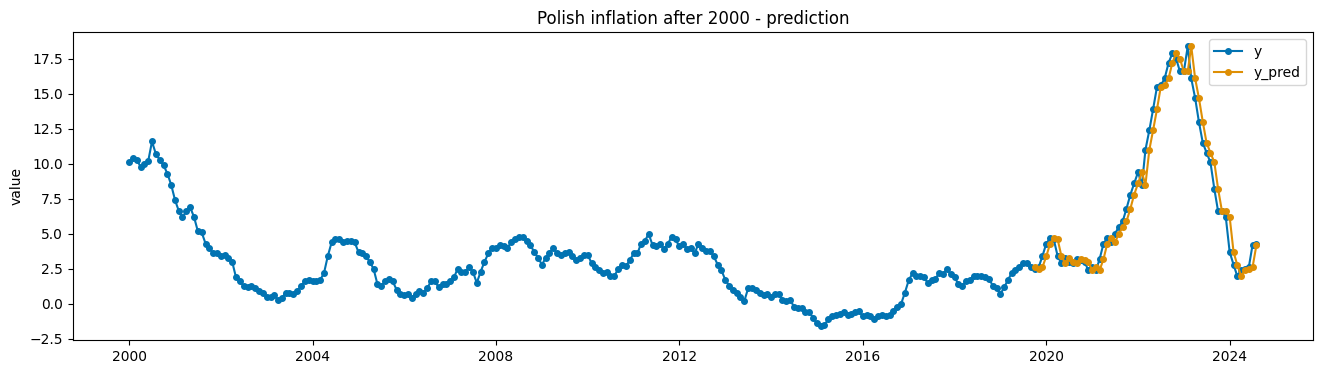

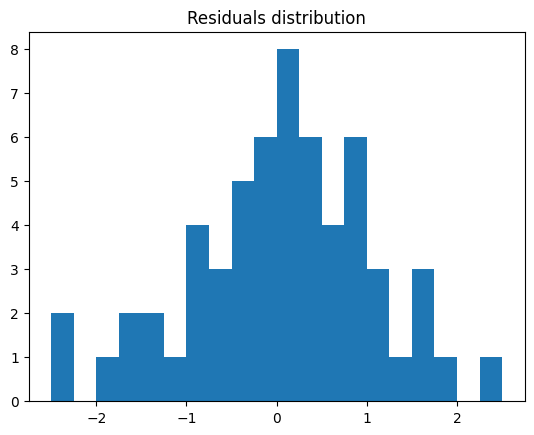

anderson-darling test:
 AndersonResult(statistic=0.32416829738895814, critical_values=array([0.543, 0.619, 0.742, 0.866, 1.03 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.028813559322033947, scale=1.0187976089925017)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


acorr_ljungbox:
       lb_stat     lb_pvalue
1   11.556617  6.750856e-04
2   17.075591  1.959217e-04
3   24.199703  2.269306e-05
4   31.430190  2.501093e-06
5   39.481288  1.899841e-07
6   42.473403  1.482538e-07
7   43.515087  2.652455e-07
8   44.754516  4.095952e-07
9   45.096153  8.856360e-07
10  45.489935  1.773892e-06


In [13]:
evaluate_model(data=df, model=last_model, plot_forecasts=True, analyze_residuals=True)

\\ comment

MAE and MASE are smaller than for mean baseline. The predicted values are closer to real data. It is better working in situation of huge change in behaviour of time serie.

The residuals are much more looking like normal distributed in histrogram. The same is confirmed by Anderson-Darling test. 

The Ljungbox test suggest autocorrelation of errors.

This baseline is much more accurate than mean baseline for these data.

Results from our first baselines look reasonable. Let's see how ETS and ARIMA will compare.

**Exercise 4 (0.75 points)**

1. Perform forecasting using the AutoETS algorithm in the damped trend variant, based on the `statsforecast` implementation ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoETS.html)). Plot forecasts and perform residuals analysis.
2. Similarly, use AutoARIMA for forecasting ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoARIMA.html)). If you didn't detect seasonality earlier, pass appropriate option to ignore SARIMA variants.
3. Comment on the results:
   - did you manage to outperform the baselines?
   - which of the models is better, and what may this mean?
   - which model is correct, at least approximately, i.e. has normally distributed, non-autocorrelated errors?
   - are the results of the best model, subjectively, good enough?

As before, use 3 month forecast horizon.

# AutoETS with 3 months horizon

MAE: 1.59
MASE: 4.64


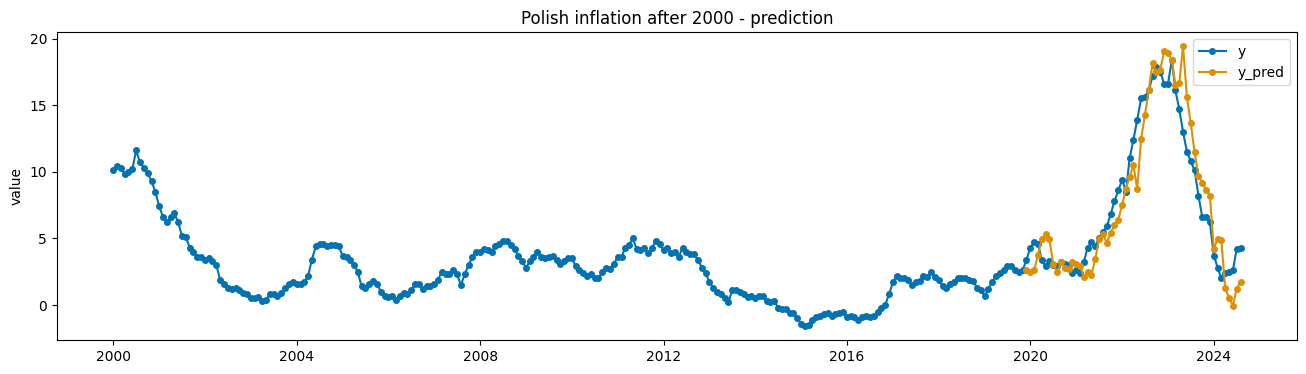

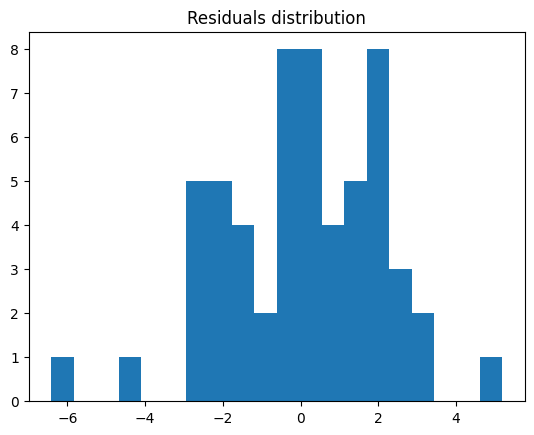

anderson-darling test:
 AndersonResult(statistic=0.35636661448860707, critical_values=array([0.542, 0.617, 0.741, 0.864, 1.028]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.032095467219402235, scale=2.0441883027421572)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


acorr_ljungbox:
       lb_stat     lb_pvalue
1   31.937272  1.592323e-08
2   42.717854  5.295854e-10
3   46.144618  5.283812e-10
4   50.275886  3.162289e-10
5   55.832678  8.797501e-11
6   59.460004  5.794006e-11
7   61.018836  9.446713e-11
8   61.672217  2.187597e-10
9   62.034280  5.426628e-10
10  62.125216  1.432520e-09


In [14]:
from sktime.forecasting.statsforecast import StatsForecastAutoETS
autoets = StatsForecastAutoETS(damped=True)  
evaluate_model(data=df, horizon=3, model=autoets, plot_forecasts=True, analyze_residuals=True)

# AutoARIMA with 3 months horizon

MAE: 1.71
MASE: 5.00


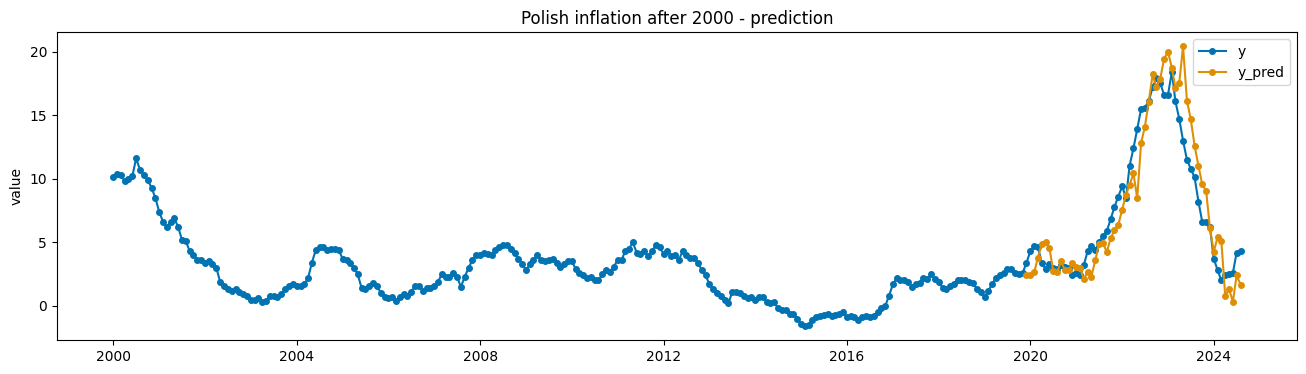

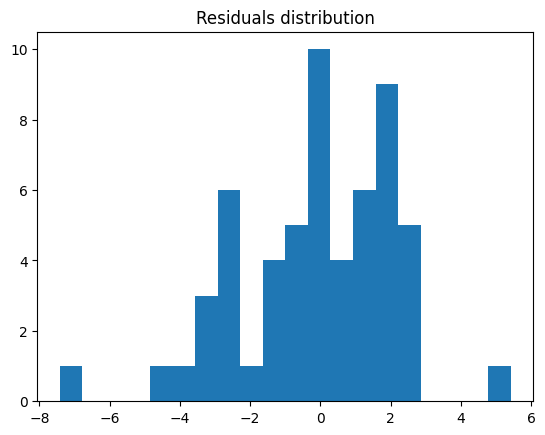

anderson-darling test:
 AndersonResult(statistic=0.8591678416135551, critical_values=array([0.542, 0.617, 0.741, 0.864, 1.028]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.1163587129903757, scale=2.2279014020381713)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


acorr_ljungbox:
       lb_stat     lb_pvalue
1   31.671116  1.826182e-08
2   45.620371  1.240687e-10
3   52.571401  2.262650e-11
4   63.223888  6.088130e-13
5   71.877090  4.166679e-14
6   76.991258  1.492475e-14
7   78.643246  2.603812e-14
8   79.686296  5.653796e-14
9   80.115356  1.533066e-13
10  80.163783  4.662714e-13


In [15]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
autoarima = StatsForecastAutoARIMA(seasonal=False)
evaluate_model(data=df, horizon=3, model=autoarima, plot_forecasts=True, analyze_residuals=True)

### AutoETS

mean:    MAE: 4.79,   MASE: 13.88     

last:    MAE: 0.78,   MASE: 2.28

autoets: MAE: 1.59, MASE: 4.64

AutoETS has smaller errors than mean baseline but greater than last baseline.

Anderson-Darling test indicates normally distributed residuals and Ljungbox test indicates residuals autocorrelation.

### AutoARIMA

autoarima:  MAE: 1.71 MASE: 5.00

AutoArima similarly to AutoETS has better errors than mean baseline but worse than last baseline. AutoARIMA has bigger errors than AutoETS.

There aren't normally distributed residuals and there is autocorrelation in residuals.

### Comparison
For this dataset better model is AutoETS it can be due to small size of dataset. AutoETS has smaller errors than AutoArima. Also AutoArima hasn't normally distributed residuals.

3 month horizon is quite short, generally speaking. The question is, what about long-term forecasting, e.g. half-yearly or yearly? They are equally, or even more interesting and relevant, e.g. for national budget planning.

**Exercise 5 (0.75 points)**

Perform forecasting for 6-month and yearly horizons, using:
- both baselines
- ETS
- ARIMA

For the best model, plot the forecasts and perform residuals analysis.

Comment:
- are there differences between models, compared to the 3-month forecasting?
- how does the quality of forecasts change for longer horizons?
- in your opinion, are those models useful at all for long-term forecasting?

In [16]:
models = [mean_model, last_model, autoets, autoarima]
models_names = ['Mean baseline', 'Last baseline', 'AutoETS', 'AutoArima']


for i in range (len(models)):
    for horizon in [6, 12]:
        print(f'\n{models_names[i]}, horizon {horizon} months:')
        evaluate_model(data=df, model=models[i], horizon=horizon, plot_forecasts=False, analyze_residuals=False)
        


Mean baseline, horizon 6 months:
MAE: 5.24
MASE: 15.66

Mean baseline, horizon 12 months:
MAE: 5.88
MASE: 18.24

Last baseline, horizon 6 months:
MAE: 3.48
MASE: 10.19

Last baseline, horizon 12 months:
MAE: 6.51
MASE: 19.55

AutoETS, horizon 6 months:
MAE: 3.11
MASE: 9.13

AutoETS, horizon 12 months:
MAE: 6.67
MASE: 20.04

AutoArima, horizon 6 months:
MAE: 3.50
MASE: 10.23

AutoArima, horizon 12 months:
MAE: 7.64
MASE: 22.72


MAE: 3.11
MASE: 9.13


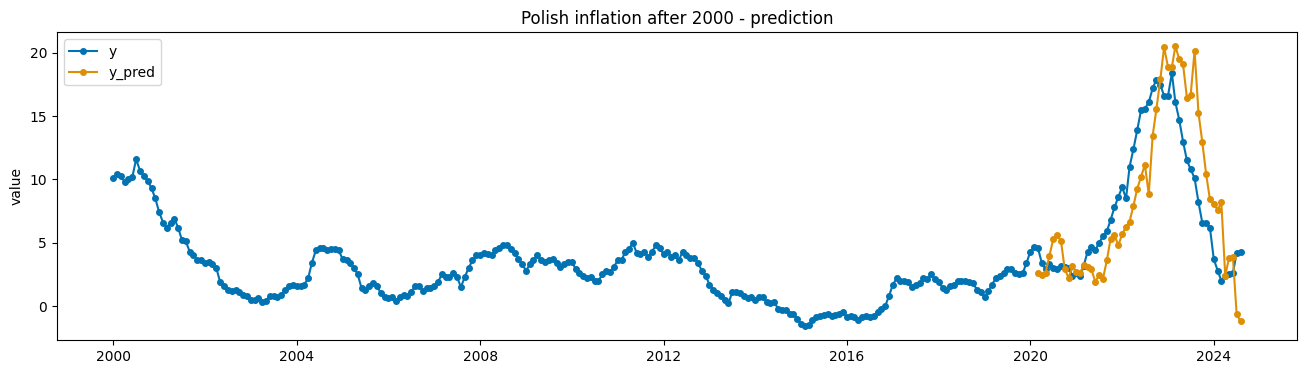

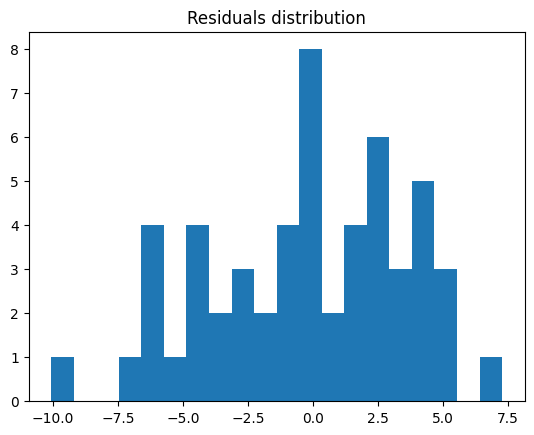

anderson-darling test:
 AndersonResult(statistic=0.4240749765237126, critical_values=array([0.541, 0.616, 0.739, 0.862, 1.025]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.20875816580081233, scale=3.847424001537877)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


acorr_ljungbox:
        lb_stat     lb_pvalue
1    40.011314  2.524961e-10
2    68.813638  1.141059e-15
3    92.833166  5.394244e-20
4   110.453321  5.825166e-23
5   123.403846  5.963781e-25
6   131.613482  5.877645e-26
7   137.220892  1.941514e-26
8   139.686560  2.757119e-26
9   139.933769  1.064637e-25
10  140.069205  4.078994e-25


In [17]:
evaluate_model(data=df, model=autoets, horizon=6, plot_forecasts=True, analyze_residuals=True)

AutoETS and AutoArima are better than baselines for 6 months horizon. But worse for 12 months horizon. The smallest errors has AutoETS for 6 months. 

AutoETS, 6 months: 

MAE: 3.11

MASE: 9.13

Normally distributed residuals. Autocorrelation of residuals.

Mean baseline is working better for longer horizon than last baseline.

In my opinion these models aren't good for long-term prediction because they don't take into account other variables. Inflation depends from many factors not only previous values.

## Forecasting network traffic

And now for something completely different. Network traffic forecasting is necessary for virtual machines (VMs) scaling, adding more servers to handle load in parallel. This is done more and more frequently by using ML models, based on time series forecasting, to scale more intelligently and avoid manually tweaking scaling rules. This is called predictive scaling, and is implemented by e.g. [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling), and [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive). There are also solutions for Kubernetes, both [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/) and [proprietary](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Time series forecasting allows lower latency and lower costs, automatically turning off machines when low demand is predicted.

Wikipedia and Google hosted [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting), where the goal was predicting the network traffic on particular Wikipedia pages. It's a really massive dataset, so we will operate on a simplified problem, where we have a total number of requests to the Wikipedia domain in millions.

Typical characteristics of such tasks are:
- short-term forecasting
- high frequency
- dynamically changing, noisy data (e.g. bot activity, web scraping)
- frequent model retraining
- high need for automatization, lack of manual model analysis

,value
2015-07-01,148.672476
2015-07-02,149.593840
2015-07-03,141.164198
2015-07-04,145.612937
2015-07-05,151.495372
...,...
2017-09-06,172.354146
2017-09-07,180.731284
2017-09-08,136.754670
2017-09-09,132.359512


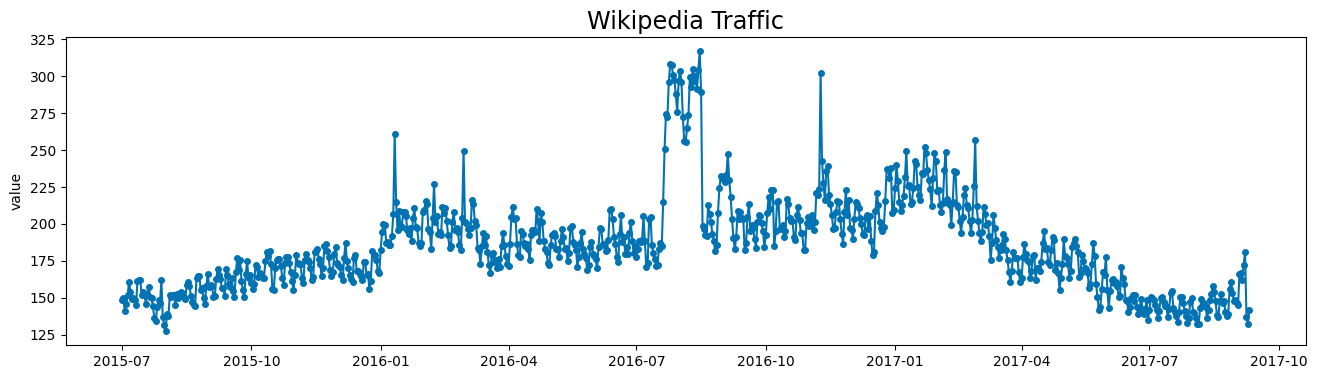

In [18]:
df_wiki = pd.read_parquet("wikipedia_traffic.parquet")
df_wiki = df_wiki.set_index("date").to_period(freq="d")
plot_series(df_wiki, title='Wikipedia Traffic')
df_wiki

**Exercise 6 (1 point)**

For 1-day horizon, train models and evaluate them (similarly to the previous dataset, with 20% test data):
- two baselines
- ETS with damped trend
- ARIMA (without seasonality)
- SARIMA

Comment:
- based on those results, is there a seasonality here?
- did you manage to outperform the baseline?

In [40]:
sarima = StatsForecastAutoARIMA(seasonal=True)
models = [mean_model, last_model, autoets, autoarima, sarima]
models_names = ['Mean baseline', 'Last baseline', 'ETS', 'ARIMA', 'SARIMA']

for i in range (len(models)):
    print(f'\n{models_names[i]}')
    evaluate_model(data=df_wiki, model=models[i], horizon=1, plot_forecasts=False, analyze_residuals=False)


Mean baseline
MAE: 33.04
MASE: 3.92

Last baseline
MAE: 6.63
MASE: 0.78

ETS
MAE: 6.63
MASE: 0.78

ARIMA
MAE: 5.27
MASE: 0.62

SARIMA
MAE: 5.27
MASE: 0.62


There is no seasonality, the results of ARIMA and SARIMA are the same.

ARIMA and SARIMA has outperformed both baselines. ETS has better results than mean baseline and the same as last baseline.

Predicting just one previous values is working the same as last baseline.

The best model was ARIMA

MAE: 5.27

MASE: 0.62

But maybe we can do better? This data is highly volatile, with high variance, which is particularly bad for ARIMA models. Let's apply the variance-stabilizing transform then. We have only positive values here, so there are no numerical problems.

Note that `Pipeline` from sktime is needed here ([documentation](https://www.sktime.net/en/stable/api_reference/pipeline.html)), which will automatically invert the transformation during prediction. Sometimes models are evaluated on the transformed data, but we are generally interested in the forecasting quality on the data in its raw form. The goal of transformations is to make the training easier for the model.

**Exercise 7 (0.5 points)**

Create a pipeline, consisting of a transform object and AutoARIMA model (without seasonality). Try out the following transformations ([documentation](https://www.sktime.net/en/stable/api_reference/transformations.html)):
- log
- sqrt
- Box-Cox

Comment, whether the result is better after the transformation or not.

In [39]:
from sktime.transformations.series.exponent import SqrtTransformer
from sktime.transformations.series.boxcox import LogTransformer, BoxCoxTransformer
from sktime.pipeline import make_pipeline

transformers = [LogTransformer(), SqrtTransformer(), BoxCoxTransformer()]
transformers_names = ['Log', 'Sqrt', 'BoxCox']

for t in range (len(transformers)):
    pipeline = make_pipeline(transformers[t], autoarima)
    print(f'\nmodel: AutoARIMA, transformer: {transformers_names[t]}')
    evaluate_model(data=df_wiki, model=pipeline, horizon=1, plot_forecasts=False, analyze_residuals=False)


model: AutoARIMA, transformer: Log
MAE: 4.99
MASE: 0.59

model: AutoARIMA, transformer: Sqrt
MAE: 5.04
MASE: 0.60

model: AutoARIMA, transformer: BoxCox
MAE: 4.90
MASE: 0.58


AutoArima without any transposition:

MAE: 5.27

MASE: 0.62

All transpositions have given better results than AutoARIMA without transposition. The best accurate was BoxCox transposition. Making dataset less variate helps in predicting.





## Sales forecasting

Arguably the most common application of time series forecasting is predicting sales, demand, costs etc., so all typical operational indicators of a company. Basically every company has to do this, therefore even basic software like Excel or PowerBI have built-in capabilities for time series forecasting.

We will focus on a task definitely vital for the Italian economy, i.e. the pasta sales. Dataset has been gathered by the Italian scientists for [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub). Data covers years 2014-2018, from 4 companies offering various pasta-based products. They also contain data about promotions for particular products. There are also missing values, which must be imputed.

Typical characteristics of this type of data are:
- positive trend, smaller or larger (changing in time)
- strong seasonality, often more than one
- highly sensitive to recurring events, e.g. weekends or holidays
- large outliers, often related to events
- relatively low frequency, daily or less frequent
- often long forecasting horizons, e.g. monthly, quarterly, yearly
- rich exogenous variables

**Exercise 8 (1 point)**

1. Read the data from `"italian_pasta.csv"` file
2. Select columns from company B1 (they have `"B1"` in their name) and `"DATE"` column.
3. Create the `value` column with total pasta sales, i.e. sum of columns with `"QTY"` in name.
4. Create the `num_promos` column with total number of promotions, i.e. sum of columns with `"PROMO"` in name.
5. Leave only columns `"DATE"`, `"value"` and `"num_promos"`.
6. Create index with type `datetime`:
   - change type of `"DATE"` colum to `datetime`
   - set its frequency as daily, `"d"`
   - set it as index
7. Split the data into:
   - `y` variable, `pd.Series` created from the `"value"` column, our main time series values
   - `X` variable, `pd.Series` created from the `"num_promos"` column, exogenous variables
8. Impute the missing values in exogenous variables with zeros, assuming that by default there are no promotions.
9. Plot the `y` time series. Remember to set the appropriate title.

In [110]:
# B1 pasta company
pasta = pd.read_csv("italian_pasta.csv")
pasta_b1 = pasta.loc[:, pasta.columns.str.contains('B1') | (pasta.columns == 'DATE')].copy()
# select columns
pasta_b1.loc[:, 'value'] = pasta.loc[:, pasta.columns.str.contains('QTY')].sum(axis=1)
pasta_b1.loc[:, 'num_promo'] = pasta.loc[:, pasta.columns.str.contains('PROMO')].sum(axis=1)
pasta_b1 = pasta_b1[['DATE', 'value', 'num_promo']]
# index
pasta_b1['DATE'] = pd.to_datetime(pasta_b1['DATE'], format='%Y-%m-%d')
pasta_b1.set_index('DATE', inplace=True)

In [111]:
pasta_b1.head()

,value,num_promo
DATE,,
2014-01-02,355,29
2014-01-03,443,29
2014-01-04,565,30
2014-01-05,259,24
2014-01-06,121,23


In [112]:
pasta_b1 = pasta_b1.asfreq('D')
x = pasta_b1['num_promo'] # exogenous
y = pasta_b1['value']

In [113]:
print(x.isna().sum())
print(y.isna().sum())

x.fillna(0, inplace=True)

print(x.isna().sum())

27
27
0


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'B1 pasta company - sales'}, ylabel='value'>)

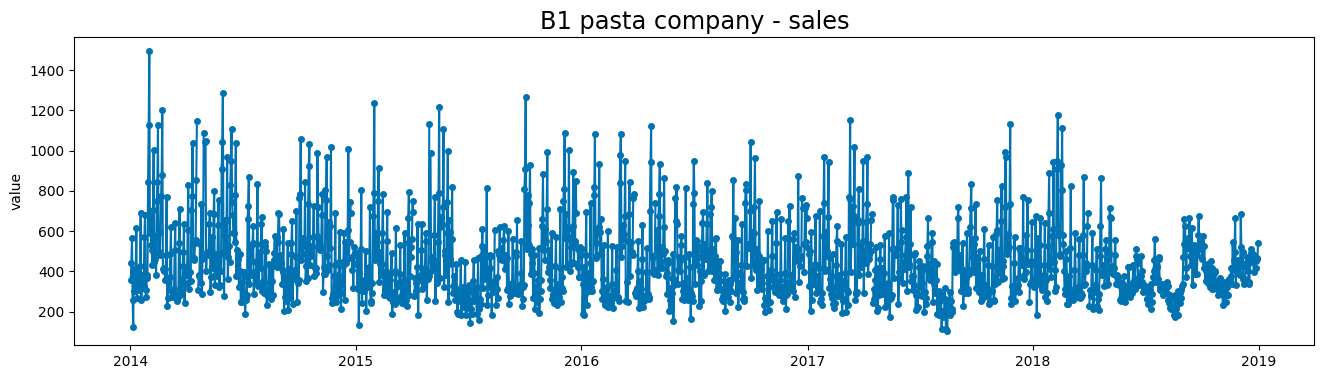

In [114]:
plot_series(y, title='B1 pasta company - sales')

We are interested in long-term forecasting. We assume that our client, an italian pasta maker, has the historical data from years 2014-2017 and wants to forecast the sales for 2018. Such information is required e.g. to make contracts for long-term supply of raw materials and next year production plans. From ML perspective this hard, since there is only a single temporal train-test split with long horizon, instead of expanding window, but it's faster.

We will use the `evaluate_pasta_sales_model` function for evaluation.

**Exercise 9 (1 point)**

Implement the missing parts of the evaluation function:
1. Split `y` into training and testing set with time split. Test set starts at `2018-01-01`.
2. If user passes `X`, split it in the same way.
3. Impute the missing values in `y`, using `Imputer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.impute.Imputer.html)) with `ffill` strategy (copy last known value).
4. Train the model (remember to pass `X`) and perform prediction.
5. Evaluate it using MAE and MASE functions ([documentation](https://www.sktime.net/en/stable/api_reference/performance_metrics.html)). Print the results rounded to 2 decimal places.
6. Copy the code for `analyze_residuals` from exercise 3.

In [95]:
from typing import Optional

import numpy as np
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.impute import Imputer


def evaluate_pasta_sales_model(
    model,
    df: pd.Series,
    X: Optional[np.ndarray] = None,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
    test_start: str = "2018-01-01",    
) -> None:
    y_train = df[df.index < test_start]
    y_test = df[df.index >= test_start]

    # impute
    transformer = Imputer(method="ffill")
    y_train_i = transformer.fit_transform(y_train)
    y_test_i = transformer.transform(y_test)

    if X is not None:
        X_train = X[df.index < test_start]
        X_test = X[df.index >= test_start]
        # impute
        X_train_i = transformer.fit_transform(X_train)
        X_test_i = transformer.fit_transform(X_test)
    else:
        X_train = None
        X_test = None


    # train and predict

    if X_train_i is not None:
        model.fit(y_train_i, X=X_train_i)
    else:
        model.fit(y_train_i)
        
    if X_test_i is not None:
        y_pred = model.predict(fh=list(range(1, len(y_test_i) + 1)), X=X_test_i)
    else:
        y_pred = model.predict(fh=list(range(1, len(y_test_i) + 1)))

    mae = mean_absolute_error(y_test_i, y_pred)
    mase = mean_absolute_scaled_error(y_test_i, y_pred, y_train = y_train_i)

    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        y_true = df[y_pred.index]
        plot_series(df, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()

    if analyze_residuals:
        y_true = df[y_pred.index]
        residual = y_true - y_pred
        residual = residual.dropna() 
        plt.hist(residual, bins=20)
        plt.title("Residuals distribution")
        plt.show()
        print('anderson-darling test:\n', anderson(residual, dist='norm'))
        print('acorr_ljungbox:\n', acorr_ljungbox(residual))


**Exercise 10 (1.5 points)**

Perform the forecasting using the following models:
- two baselines
- ETS with damped trend
- ARIMA
- SARIMA with 30-day seasonality
- ARIMAX
- SARIMAX with 30-day seasonality

For the best model also try the log, sqrt and Box-Cox transformations.

For the final model plot the forecasts and perform residuals analysis.

Comment:
- did you outperform the baseline?
- does the final model use seasonality and/or exogenous variables (data about promotions)?
- was it worth it to use the variance-stabilizing transformation?
- comment on the general behavior of the model on the test set, based on the forecast plot
- is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?

In [85]:
from sktime.forecasting.sarimax import SARIMAX
sarima30 = StatsForecastAutoARIMA(seasonal=True, sp=30)
arimax = SARIMAX()
sarimax = SARIMAX(order=(1, 0, 0), seasonal_order=(1, 0, 0, 30))

In [86]:
models = [mean_model, last_model, autoets, autoarima, sarima30, arimax, sarimax]
models_names = ['Mean baseline', 'Last baseline', 'ETS', 'ARIMA', 'SARIMA30', 'ARIMAX', 'SARIMAX']

In [87]:
for m in range(len(models)):
    print(f'\nmodel: {models_names[m]}')
    evaluate_pasta_sales_model(models[m], df=y, X=x, plot_forecasts=False, analyze_residuals=False)


model: Mean baseline
MAE: 123.97
MASE: 0.85

model: Last baseline
MAE: 106.10
MASE: 0.72

model: ETS
MAE: 106.65
MASE: 0.73

model: ARIMA
MAE: 94.96
MASE: 0.65

model: SARIMA30
MAE: 93.57
MASE: 0.64

model: ARIMAX
MAE: 114.70
MASE: 0.78

model: SARIMAX
MAE: 114.73
MASE: 0.78


The best model was SARIMA with 30-day seasonality. Exogenous variable wasn't useful in this case. SARIMA has outperformed both baselines.

MAE: 93.57

MASE: 0.64

In [88]:
transformer_names = ['Log', 'Sqrt', 'BoxCox']
transformers = [LogTransformer(), SqrtTransformer(), BoxCoxTransformer()]

In [92]:
from sktime.pipeline import make_pipeline
for i in range (len(transformers)):
    print(f'\nTransformation: {transformer_names[i]}')
    pipeline = make_pipeline(transformers[i], sarima)
    evaluate_pasta_sales_model(pipeline, df=y, X=x, plot_forecasts=False, analyze_residuals=False)


Transformation: Log
MAE: 88.22
MASE: 0.60

Transformation: Sqrt
MAE: 90.54
MASE: 0.62

Transformation: BoxCox
MAE: 87.76
MASE: 0.60


MAE: 87.76
MASE: 0.60


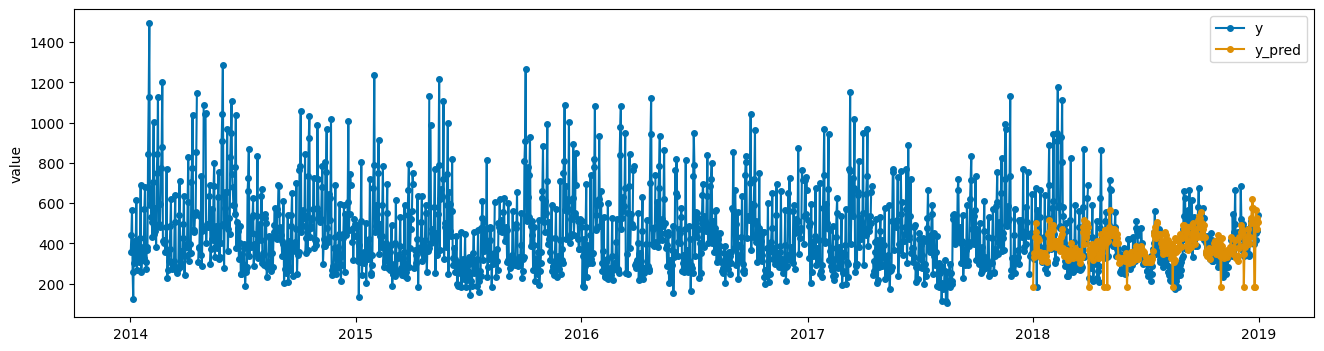

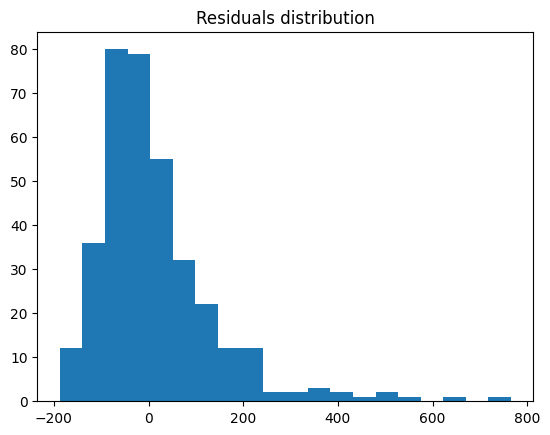

anderson-darling test:
 AndersonResult(statistic=12.39459739847672, critical_values=array([0.57 , 0.649, 0.778, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=13.217432438868352, scale=125.36767650198203)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
acorr_ljungbox:
        lb_stat     lb_pvalue
1   107.165604  4.094822e-25
2   144.587640  4.010448e-32
3   152.621979  7.163496e-33
4   158.942418  2.464523e-33
5   180.248415  4.735741e-37
6   233.921351  1.114550e-47
7   379.592215  5.655457e-78
8   419.584296  1.207450e-85
9   429.351075  7.418201e-87
10  429.389873  5.180584e-86


In [96]:
pipeline = make_pipeline(BoxCoxTransformer(), sarima)
evaluate_pasta_sales_model(pipeline, df=y, X=x, plot_forecasts=True, analyze_residuals=True)

SARIMA without transformation:

MAE: 93.57

MASE: 0.64 

It was worth to use variance-stabilizing transformation. All transformations has outperformed model without transformations. The best results got SARIMA with BoxCox transformation.

SARIMA with BoxCox:

MAE: 87.76

MASE: 0.60

Model on the test set tries to fit in the middle of series, to get general trend and general fluctuation not every single variation.

Anderson-Darling says it is not normally distributed residuals but after looking at plot it looks quite normally distributed with mean at 0. But long right tail with small values can missed the test.

The best model was just SARIMA, an exogenous variable wasn't useful. Maybe using another exogenous variables could improve the model.

Exogenous variables can be expanded with feature engineering. For example, the behavior of clients is quite different during weekends and holidays. Typically sales rise quite sharply before and after days when stores are closed, and falls to exactly zero when they have to be closed.

**Exercise 11 (0.75 points)**

1. Create a list of variables for holidays using `HolidayFeatures` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.holiday.HolidayFeatures.html)):
   - use `country_holidays` function from the holidays library
   - remember that we are processing italian data, with country identifier `"IT"`
   - include weekends as holidays
   - create a single variable "is there a holiday" (`return_dummies` and `return_indicator` options)
2. Add those features to our exogenous variables `X`. Use `pd.merge` function, `left_index` and `right_index` options may be useful.
3. Train the ARIMAX model (or SARIMAX, if you detected seasonality before). Use the best transformation from the previous exercise.
4. Comment on the results, and compare them to the previous ones.

In [133]:
from sktime.transformations.series.holiday import HolidayFeatures
from holidays import country_holidays

holidays_transformer = HolidayFeatures(
   calendar=country_holidays(country="IT"),
    include_weekend=True,
    return_dummies=True,
    return_indicator=True)

is_there_a_holiday = holidays_transformer.fit_transform(x)

In [134]:
x_holidays = pd.merge(x, is_there_a_holiday, left_index=True, right_index=True, how='left')

In [135]:
x_holidays.head()

,num_promo,Assunzione della Vergine,Capodanno,Epifania del Signore,Festa dei Lavoratori,Festa della Liberazione,Festa della Repubblica,Immacolata Concezione,Lunedì dell'Angelo,Natale,Santo Stefano,Tutti i Santi,Weekend,is_holiday
2014-01-02,29.0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
2014-01-03,29.0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
2014-01-04,30.0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.000000,1.000000
2014-01-05,24.0,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.000000,1.000000
2014-01-06,23.0,0.000001,0.000001,1.000000,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,1.000000


In [136]:
from sktime.pipeline import make_pipeline
pipeline = make_pipeline(BoxCoxTransformer(), SARIMAX())

MAE: 95.80
MASE: 0.65


C:\Users\Monika\miniconda3\envs\seriesenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


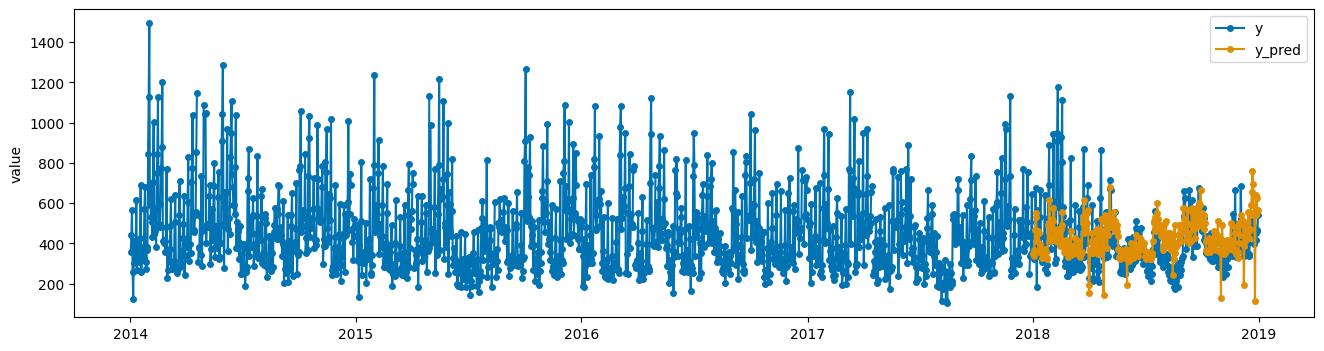

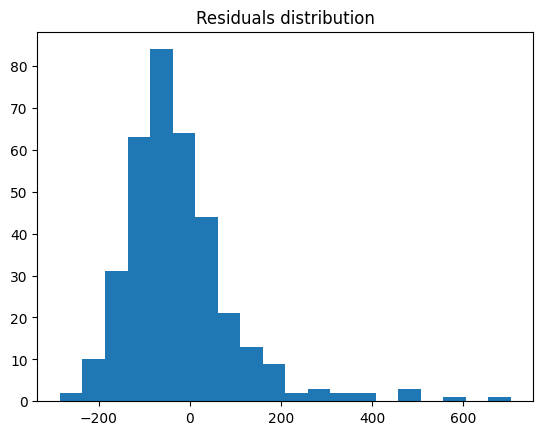

anderson-darling test:
 AndersonResult(statistic=9.431641960949662, critical_values=array([0.57 , 0.649, 0.778, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-24.528127425146593, scale=123.0702285255418)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
acorr_ljungbox:
        lb_stat     lb_pvalue
1   114.813364  8.646393e-27
2   159.556250  2.253204e-35
3   172.023865  4.652963e-37
4   183.382797  1.399494e-38
5   209.352626  2.831390e-43
6   259.906304  3.128171e-53
7   391.155425  1.879141e-80
8   432.952959  1.657955e-88
9   444.345348  4.637365e-90
10  444.503524  3.106756e-89


In [138]:
evaluate_pasta_sales_model(pipeline, df=y, X=x_holidays, plot_forecasts=True, analyze_residuals=True)

Adding extra variables didn't help in this case. The errors are a little greater. Still autocorrelated residuals and not normally distributed by tests. But looking at plot it is quite normally distributed.